# Lec 22: Dimensionality Reduction

**by Josh Hug (Fall 2019)**

In [1]:
# Lec 20: Decision Trees

**by Josh Hug (Fall 2019)**import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

We often create visualizations in order to facilitate exploratory data analysis. For example, we might create scatterplots to explore the relationship between pairs of variables in a dataset. Below, we see weight vs. height.

In [2]:
df = pd.read_csv("hongkong_height_weight.csv")
df.head(5)

,Height,Weight
0,65.78331,112.9925
1,71.51521,136.4873
2,69.39874,153.0269
3,68.21660,142.3354
4,67.78781,144.2971


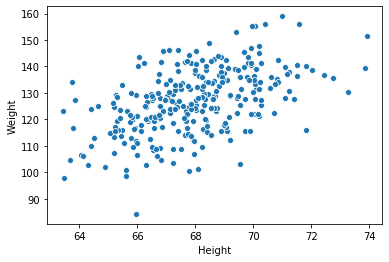

In [3]:
sns.scatterplot(data = df, x = "Height", y = "Weight");

The dataset below gives the "percentage body fat, age, weight, height, and ten body circumference measurements" for 252 men.

http://jse.amstat.org/v4n1/datasets.johnson.html

For simplicity, we read in only 8 of the provided attributes, yielding the given dataframe.

In [4]:
#http://jse.amstat.org/datasets/fat.txt
df3 = pd.read_fwf("fat.dat.txt", colspecs = [(17, 21), (23, 29), (35, 37),
                                             (39, 45), (48, 53), (73, 77),
                                            (80, 85), (88, 93)], header=None, names = ["% fat", "density", "age", "weight", "height", "neck", "chest", "abdomen"])
df3.head()

,% fat,density,age,weight,height,neck,chest,abdomen
0,12.3,1.0708,23,154.25,67.75,36.2,93.1,85.2
1,6.1,1.0853,22,173.25,72.25,38.5,93.6,83.0
2,25.3,1.0414,22,154.00,66.25,34.0,95.8,87.9
3,10.4,1.0751,26,184.75,72.25,37.4,101.8,86.4
4,28.7,1.0340,24,184.25,71.25,34.4,97.3,100.0


We see that percentage fat and density in g/cm^3 are almost completely redundant.

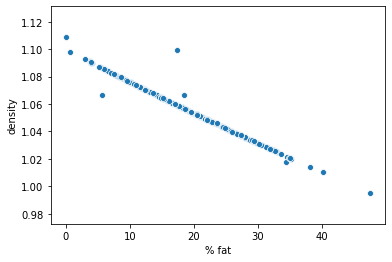

In [5]:
sns.scatterplot(data = df3, x = "% fat", y = "density");

By contrast, while there is a strong correlation between neck and chest measurements, the resulting data is very 2 dimensional.

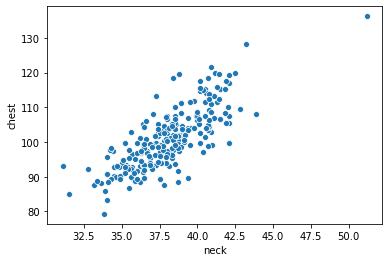

In [6]:
sns.scatterplot(data = df3, x = "neck", y = "chest");

Age and height show a small correlation as peolpe seem to get slightly smaller with greater age in this dataset.

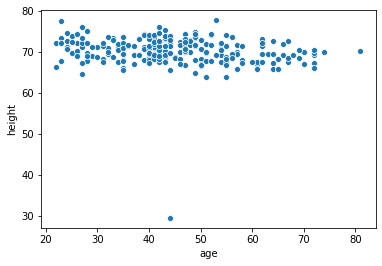

In [7]:
sns.scatterplot(data = df3, x = "age", y = "height");

We note that there is one outlier where a person is slightly less than 29.5 inches tall. While there are a extraordinarily small number of adult males who are less than three feet tall, reflection on the rest of the data from this observation suggest that this was simply an error.

In [8]:
df3.query("height < 40")

,% fat,density,age,weight,height,neck,chest,abdomen
41,32.9,1.025,44,205.0,29.5,36.6,106.0,104.3


In [9]:
df3 = df3.drop(41)

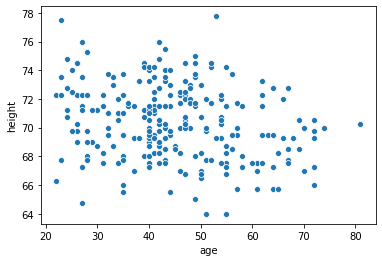

In [10]:
sns.scatterplot(data = df3, x = "age", y = "height");

We can try to visualize more than 2 attributes at once, but the relationships displayed in e.g. the color and dot size space are much harder for human readers to see. For example, above we saw that density and % fat are almost entirely redundant, but this relationship is impossible to see when comparing the colors and dot sizes.

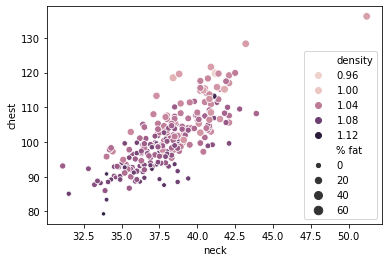

In [11]:
sns.scatterplot(data = df3, x = "neck", y = "chest", hue="density", size = "% fat");

Seaborn gives us the ability to create a matrix of all possible pairs of variables. This is can be useful, though even with only 8 variables it's still difficult to fully digest.

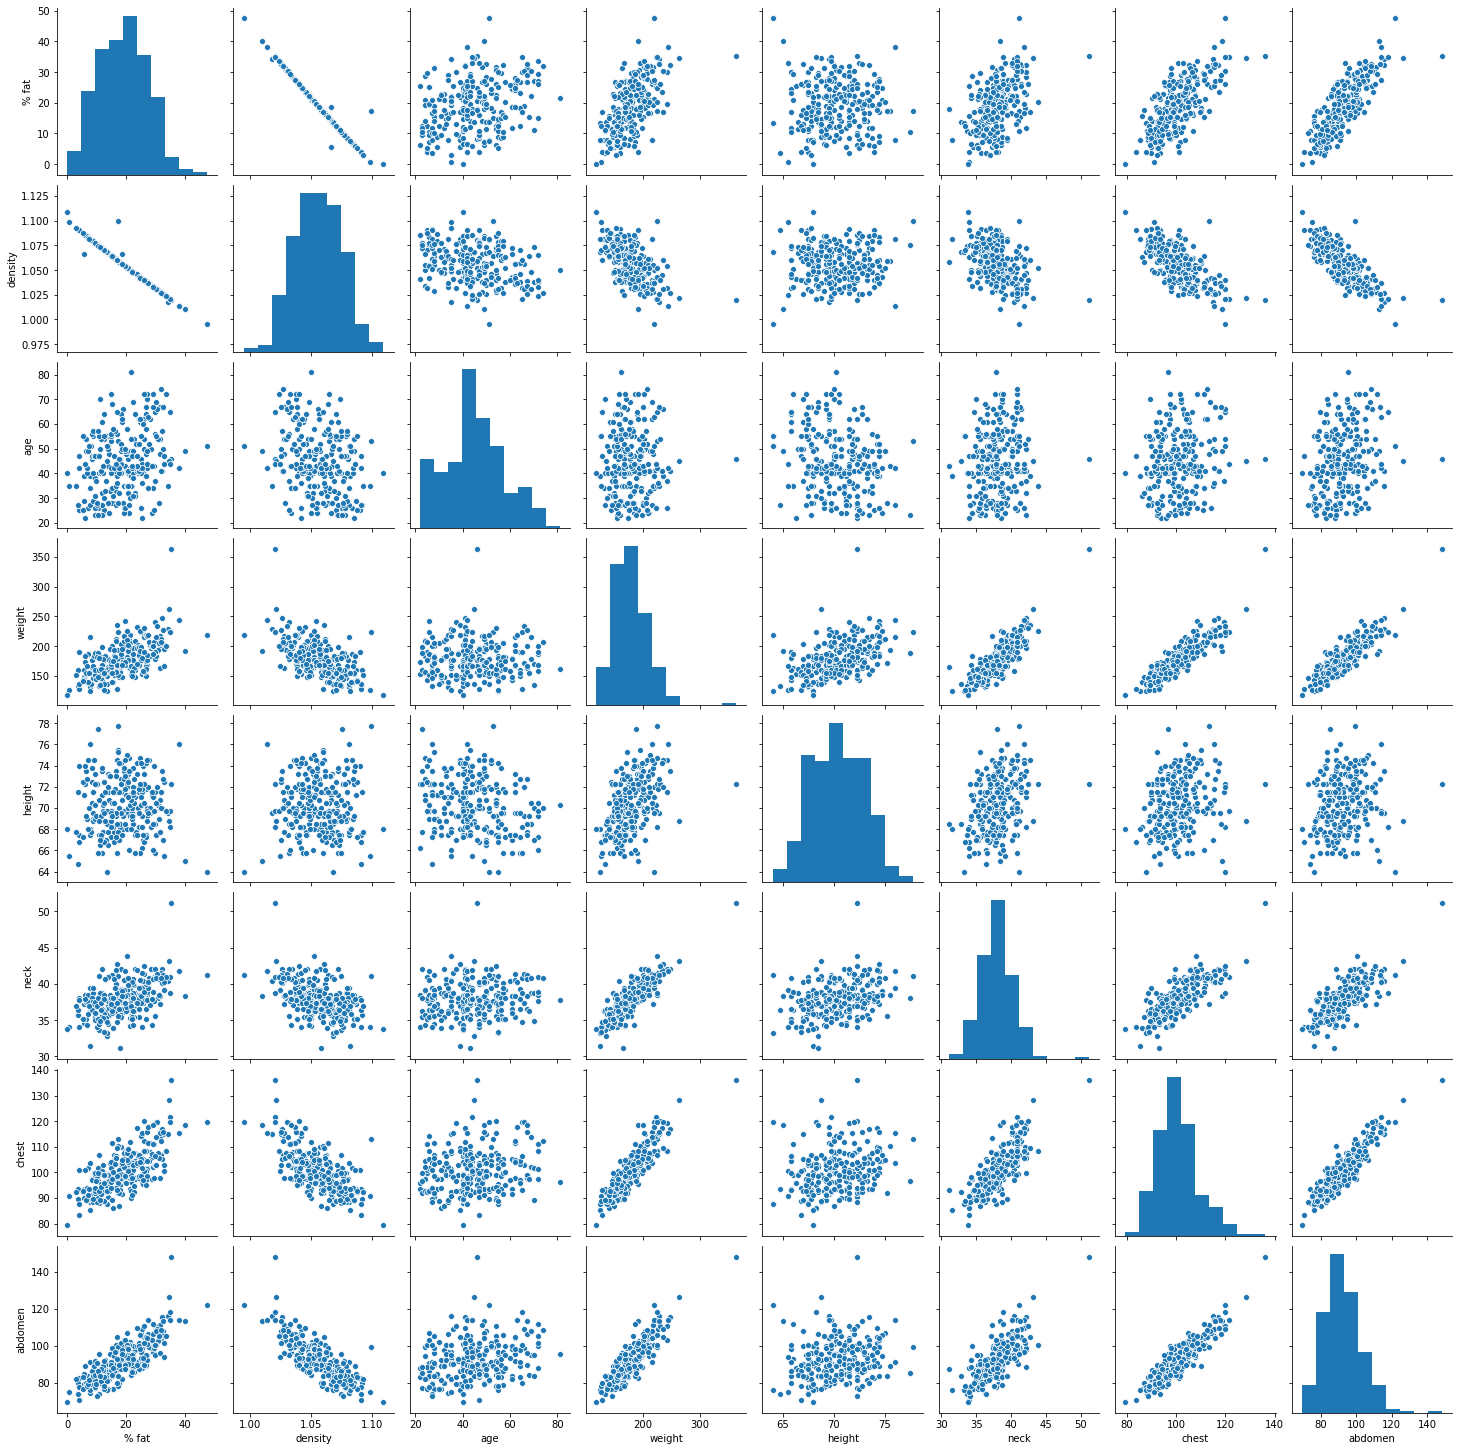

In [12]:
sns.pairplot(df3);

We should note that despite the very strong relationship between % fat and density, the numerical rank of the data matrix is still 8. For the rank to be 7, we'd need the data to be almost exactly on a line. We'll talk about techniques to reduce the dimensionality over the course of this lecture and the next.

In [13]:
np.linalg.matrix_rank(df3)

8

## House of Representatives Voting Data

Next, let's consider voting data from the house of representatives in the U.S. during the month of September 2019. In this example, our goal will be to try to find clusters of representatives who vote in similar ways. For example, we might expect to find that Democrats and Republicans vote similarly to other members of their party.

In [14]:
from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [15]:
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Downloading... Done!


/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [16]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('votes.csv')
votes = votes.astype({"roll call": str}) 
votes.head()

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [17]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,vote,leg_id,first,last,gender,state,chamber_y,party,birthday
4112,House,1,526,D000617,No,D000617,Suzan,DelBene,F,WA,rep,Democrat,1962-02-17
9599,House,1,533,L000576,No,L000576,Billy,Long,M,MO,rep,Republican,1955-08-11
1060,House,1,520,B000490,No,B000490,Sanford,Bishop,M,GA,rep,Democrat,1947-02-04
9,House,1,546,A000374,Not Voting,A000374,Ralph,Abraham,M,LA,rep,Republican,1954-09-16
16427,House,1,535,W000819,Yes,W000819,Mark,Walker,M,NC,rep,Republican,1969-05-20


In [18]:
def was_yes(s):
    if s.iloc[0] == 'Yes':
        return 1
    else:
        return 0

In [19]:
vote_pivot = votes.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=was_yes, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


In [20]:
vote_pivot.shape

(441, 41)

This data has 441 observations (members of the House of Representatives including the 6 non-voting representatives) and 41 dimensions (votes). While politics is quite polarized, none of these columns are linearly dependent as we note below.

In [21]:
np.linalg.matrix_rank(vote_pivot)

41

Suppose we want to find clusters of similar voting behavior. We might try by reducing our data to only two dimensions and looking to see if we can identify clear patterns. Let's start by looking at what votes were most controversial.

In [22]:
np.var(vote_pivot, axis=0).sort_values(ascending = False)

roll call
555    0.249988
540    0.249896
530    0.249896
537    0.249783
542    0.249783
533    0.249711
534    0.249711
536    0.249711
543    0.249711
550    0.249628
552    0.249536
549    0.249536
546    0.249536
518    0.249433
517    0.249320
547    0.249320
545    0.249063
553    0.248765
525    0.248425
551    0.248240
531    0.247397
524    0.246389
526    0.246111
521    0.246111
529    0.244898
528    0.244230
527    0.243150
520    0.242378
523    0.241144
522    0.231796
539    0.231796
516    0.221461
538    0.216679
544    0.198066
515    0.112546
541    0.095218
554    0.078743
532    0.071153
535    0.051460
519    0.047398
548    0.043295
dtype: float64

We see that roll call 548 had very little variance. According to [http://clerk.house.gov/evs/2019/roll548.xml](http://clerk.house.gov/evs/2019/roll548.xml), this bill was referring to the 2019 Whistleblower Complaint about President Trump and Ukraine. The full text of the house resolution for this roll call can be found at [https://www.congress.gov/bill/116th-congress/house-resolution/576/text](https://www.congress.gov/bill/116th-congress/house-resolution/576/text):

(1) the whistleblower complaint received on August 12, 2019, by the Inspector General of the Intelligence Community shall be transmitted immediately to the Select Committee on Intelligence of the Senate and the Permanent Select Committee on Intelligence of the House of Representatives; and

(2) the Select Committee on Intelligence of the Senate and the Permanent Select Committee on Intelligence of the House of Representatives should be allowed to evaluate the complaint in a deliberate and bipartisan manner consistent with applicable statutes and processes in order to safeguard classified and sensitive information.

We see that 421 congresspeople voted for this resolution, and 12 did not vote for this resolution. 2 members answered "present" but did not vote no, and 10 did not vote at all. Clearly, a scatterplot involving this particular dimension isn't going to be useful.

In [23]:
vote_pivot['548'].value_counts()

1    421
0     20
Name: 548, dtype: int64

By contrast, we saw high variance for most of the other roll call votes. Most them had variances near 0.25, which is the maximum possible for a variable which can take on values 0 or 1. Let's consider the two highest variance variables, shown below:

In [24]:
vote_pivot['555'].value_counts()

1    222
0    219
Name: 555, dtype: int64

In [25]:
vote_pivot['530'].value_counts()

1    225
0    216
Name: 530, dtype: int64

Let's use these as our two dimensions for our scatterplot and see what happens.

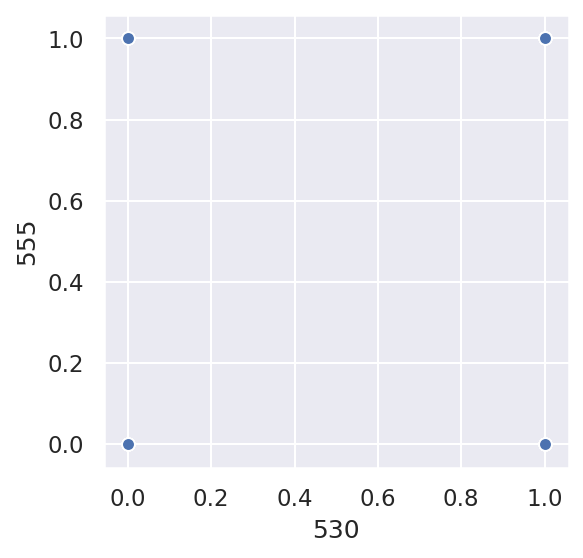

In [26]:
sns.scatterplot(x='530', y='555', data=vote_pivot);

By adding some random noise, we can get rid of the overplotting.

In [27]:
vote_pivot_jittered = vote_pivot.copy()
vote_pivot_jittered.loc[:, '515':'555'] += np.random.random(vote_pivot_jittered.loc[:, '515':'555'].shape) * 0.3

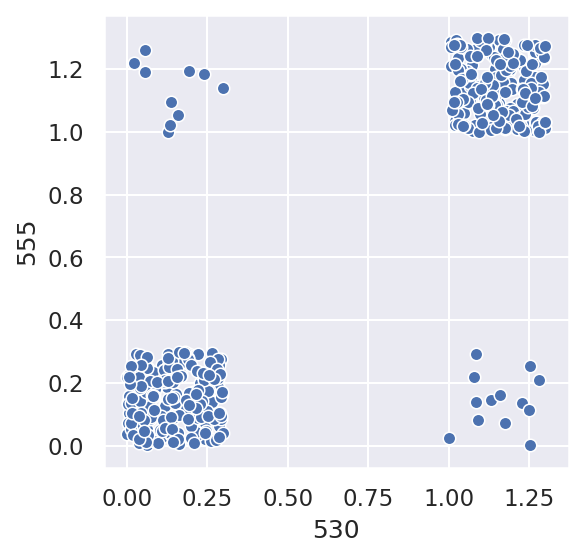

In [28]:
sns.scatterplot(x='530', y='555', data=vote_pivot_jittered);

We can also look at this data labeled by party.

In [29]:
vote_pivot_labeled = vote_pivot.reset_index().merge(legs, left_on='member', right_on='leg_id').set_index('member')
vote_pivot_labeled.head(5)

,515,516,517,518,519,520,521,522,523,524,...,554,555,leg_id,first,last,gender,state,chamber,party,birthday
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,1,0,A000055,Robert,Aderholt,M,AL,rep,Republican,1965-07-22
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,A000367,Justin,Amash,M,MI,rep,Libertarian,1980-04-18
A000369,1,1,0,0,1,1,0,1,1,1,...,1,0,A000369,Mark,Amodei,M,NV,rep,Republican,1958-06-12
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,A000370,Alma,Adams,F,NC,rep,Democrat,1946-05-27
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,A000371,Pete,Aguilar,M,CA,rep,Democrat,1979-06-19


In [30]:
vote_pivot_labeled_jittered = vote_pivot_labeled.copy()
vote_pivot_labeled_jittered.loc[:, '515':'555'] += np.random.random(vote_pivot_labeled_jittered.loc[:, '515':'555'].shape) * 0.3

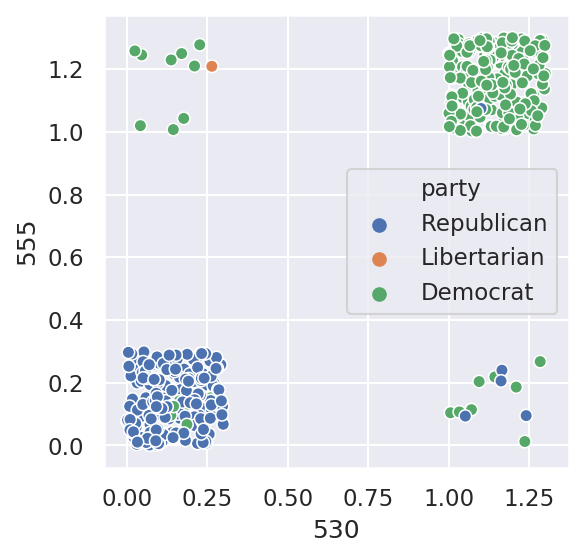

In [31]:
sns.scatterplot(x='530', y='555', data=vote_pivot_labeled_jittered, hue="party");

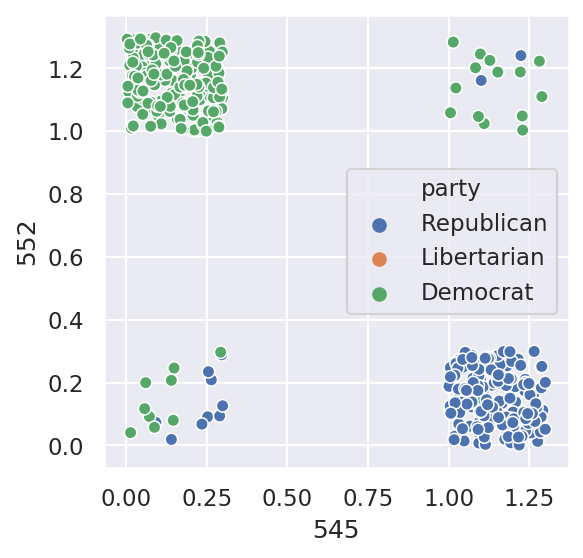

In [32]:
sns.scatterplot(x='545', y='552', data=vote_pivot_labeled_jittered, hue="party");

We see that considering only two votes does seem to do a pretty good job of telling Republicans from Democrats. We'll see in the next lecture how we can do even better using a technique called "Principle Component Analysis" or PCA.

Before we can get there, we'll need to spend some time reviewing key linear algebra principles.

## Matrix Operations in Python

In [33]:
age_and_height = np.array([[182, 28], [399, 30], [725, 33]])

In [34]:
M = np.array([[1, 0, 0], [0, 1, 1/12]])

In [35]:
age_and_height @ M

array([[182.        ,  28.        ,   2.33333333],
       [399.        ,  30.        ,   2.5       ],
       [725.        ,  33.        ,   2.75      ]])

## Singular Value Decomposition Experiment

### Manual Decomposition

In the table below, we have the width, height, area, and perimeter of a rectangle stored in a dataframe.

In [36]:
rectangle = pd.read_csv("rectangle_data.csv")
rectangle.head(5)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34


Naturally the perimeter is just the sum of 2x the width and 2x the height. Thus, if we create a new dataframe that has only the width, height, and area...

In [37]:
rectangle_no_perim = rectangle[["width", "height", "area"]]
rectangle_no_perim.head(5)

,width,height,area
0,8,6,48
1,2,4,8
2,1,3,3
3,9,3,27
4,9,8,72


... then we can recover the perimeter by multiplying this matrix by

`1   0   0   2
0   1   0   2
0   0   1   0`

In [38]:
transform_3D_to_4D = [[1, 0, 0, 2], [0, 1, 0, 2], [0, 0, 1, 0]]

In [39]:
rectangle_with_perimeter_back = np.array(rectangle_no_perim) @ transform_3D_to_4D
pd.DataFrame(rectangle_with_perimeter_back, columns = ["width", "height", "area", "perimeter"]).head(5)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34


### Singular Value Decomposition Example

Singular value decomposition is a numerical technique to (among other things) automatically uncover such redundancies. Given an input matrix X, SVD will return $U\Sigma$ and $V^T$ such that $ X = U \Sigma V^T $.

In [40]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)

As we did before with our manual decomposition, we can recover our original rectangle data by multiplying the three return values of this function back together.

In [41]:
pd.DataFrame(u * s @ vt).head(4)

,0,1,2,3
0,8.0,6.0,48.0,28.0
1,2.0,4.0,8.0,12.0
2,1.0,3.0,3.0,8.0
3,9.0,3.0,27.0,24.0


The two key pieces of the decomposition are $U\Sigma$ and $V^T$, which we can think of for now as analogous to our 'data' and 'transformation operation' from our manual decomposition earlier.

Let's start by looking at $U\Sigma$, which we can compute with the Python code `u*s`.

In [42]:
u*s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

Similarly, we can look at vt.

In [43]:
vt

array([[-1.46435746e-01, -1.29942186e-01, -8.10020095e-01,
        -5.52755864e-01],
       [-1.92735898e-01, -1.89127741e-01,  5.86348204e-01,
        -7.63727278e-01],
       [-7.04957447e-01,  7.09155330e-01,  7.95161387e-03,
         8.39576575e-03],
       [-6.66666667e-01, -6.66666667e-01, -1.08794322e-16,
         3.33333333e-01]])

The automatic decomposition returned by the svd function looks quite different than what we got when we manually decomposed our data into "data" and "operations". That is, vt is a bunch of seemingly arbitrary numbers instead of the rather simple:

`1   0   0   2
0   1   0   2
0   0   1   0`

Similarly, if we look at the shape of $U\Sigma$ and $V^T$ we see that they are bigger than in our manual decomposition. Specifically $U\Sigma$ still has 4 columns, meaning that each observation is 4 dimensional. Furthermore, rather than our transformation operation $V^T$ being 3x4, it's 4x4 rows tall, meaning that it maps 4 dimensional inputs back to 4 dimensions.

This seems problematic, because our goal of using SVD was to find a transformation operation that takes 3D inputs and maps them up to 4 dimensions.

Luckily, if we look carefully at $U\Sigma$, we see that the last attribute of each observation is very close to 0. 

In [44]:
u * s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

Thus, it makes sense that we remove the last column of $U \Sigma$. 

In [45]:
u = u[:, 0:3]
s = s[0:3]
u * s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00],
       [-4.08780385e+01, -1.86471027e+00, -2.34708823e+00],
       [-5.34289549e+00, -3.98065864e+00,  7.79631035e-01],
       [-2.82033419e+01, -8.33535389e+00,  5.30031897e+00],
       [-6.40083890e+01,  7.06150790e+00,  1.43570386e+00],
       [-4.32916052e+01, -1.02057499e-01

Similarly, because the observations are now 3D, we should remove the last row of $V^T$, since we want to use $V^T$ to map our now 3D data into 4D (rather than expecting 4D input data).

In [46]:
vt = vt[0:3, :]

After removing the redundant portions of $U\Sigma$ and $V^T$, we can verify that multiplying them together again yields our original array.

In [47]:
u * s @ vt

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.],
       [ 3.,  1.,  3.,  8.],
       [ 4.,  2.,  8., 12.],
       [ 6.,  5., 30., 22.],
       [ 7.,  1.,  7., 16.],
       [ 8.,  2., 16., 20.],
       [ 5.,  5., 25., 20.],
       [ 9.,  5., 45., 28.],
       [ 8.,  4., 32., 24.],
       [ 1.,  2.,  2.,  6.],
       [ 2.,  9., 18., 22.],
       [ 7.,  8., 56., 30.],
       [ 7.,  5., 35., 24.],
       [ 2.,  4.,  8., 12.],
       [ 2.,  5., 10., 14.],
       [ 4.,  3., 12., 14.],
       [ 8.,  1.,  8., 18.],
       [ 8.,  5., 40., 26.],
       [ 9.,  8., 72., 34.],
       [ 7.,  3., 21., 20.],
       [ 8.,  3., 24., 22.],
       [ 6.,  6., 36., 24.],
       [ 6.,  4., 24., 20.],
       [ 8.,  4., 32., 24.],
       [ 7.,  2., 14., 18.],
       [ 4.,  4., 16., 16.],
       [ 4.,  1.,  4., 10.],
       [ 9.,  7., 63., 32.],
       [ 4.,  2.,  8., 12.],
       [ 1.,  2.,  2.,  6.],
       [ 8.,  

## Singular Value Decomposition Experiment

The reasons that $U \Sigma$ and $V^T$ look so different than the results of our manual decomposition are a consequence of how singular value decomposition. Specifically, given X, SVD computers $U$, $\Sigma$, and $V$ such that:
1. $\Sigma$ is a diagonal matrix containing the singular values of X.
2. $U$ and $V$ are matrices whose columns form an orthonormal set.
3. $X = U \Sigma V^T$

That is, there are an infinite number of matrices such that $X = AB$. In our example above, we created A and B through manual calculation and insight (recognizing that perimeter was 2*w + 2*h). SVD computes them automatically, and the results have the specific properties enumerated above.

In [48]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)

### The Singular Values Matrix $\Sigma$

The middle result returned by the SVD process is a diagonal matrix consisting of the singular values. We won't say a lot about what they mean today, but we will note that if the matrix is of rank r, then the first r singular values will be non-zero, and the rest will be zero.

In [49]:
s

array([3.62932568e+02, 6.29904732e+01, 2.56544651e+01, 4.29718368e-15])

Python returns the singular values in a slightly funny format (as a list). To get them into the correct form, we can use `diag(s)`.

In [50]:
np.diag(s)

array([[3.62932568e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.29904732e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.56544651e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.29718368e-15]])

If we do this, then we can compute the original matrix using only the matrix multiplication operator. That is, rather than writing `u * s @ vt`, we can do `u @ np.diag(s) @ vt`.

In [51]:
(u @ np.diag(s) @ vt)[0:5, :]

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.]])

The fact that the last singular value is zero is why we were able to remove the last dimension of $U$ and the last operation in $V^T$. That is, since the last column of $U \Sigma$ is always zero, we can just remove it completely.

In [52]:
(u @ np.diag(s))

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

In [53]:
(u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :])[0:5, :]

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.]])

### $U$ and $V^T$

Let's try verifying that $U$ is orthonormal. If so, any column dot producted with itself should be 1, and any columns dot producted with any other should be zero.

In [54]:
np.dot(u[:, 0], u[:, 0])

1.0000000000000009

In [55]:
np.dot(u[:, 1], u[:, 1])

1.000000000000001

In [56]:
np.dot(u[:, 2], u[:, 2])

1.0

In [57]:
for i in range(0, u.shape[1]):
    print(f"row {i} dot producted with itself is {np.dot(u[:, i], u[:, i])}")

row 0 dot producted with itself is 1.0000000000000009
row 1 dot producted with itself is 1.000000000000001
row 2 dot producted with itself is 1.0
row 3 dot producted with itself is 1.0


In [58]:
for i in range(0, u.shape[1]):
    for j in range(i + 1, u.shape[1]):
        print(f"row {i} dot producted with {j} is {np.dot(u[:, i], u[:, j])}")

row 0 dot producted with 1 is -1.3877787807814457e-17
row 0 dot producted with 2 is -1.5959455978986625e-16
row 0 dot producted with 3 is 1.1102230246251565e-16
row 1 dot producted with 2 is -1.5265566588595902e-16
row 1 dot producted with 3 is 3.469446951953614e-17
row 2 dot producted with 3 is -2.7755575615628914e-17


Let's now look at $V$.

In [59]:
v = vt.T

In [60]:
for i in range(0, v.shape[1]):
    print(f"row {i} of V dot producted with itself is {np.dot(v[:, i], v[:, i])}")

row 0 of V dot producted with itself is 0.9999999999999999
row 1 of V dot producted with itself is 0.9999999999999991
row 2 of V dot producted with itself is 0.9999999999999994
row 3 of V dot producted with itself is 0.9999999999999998


In [61]:
for i in range(0, v.shape[1]):
    for j in range(i + 1, v.shape[1]):
        print(f"row {i} of V dot producted with {j} is {np.dot(v[:, i], v[:, j])}")

row 0 of V dot producted with 1 is -9.71445146547012e-17
row 0 of V dot producted with 2 is -2.42861286636753e-17
row 0 of V dot producted with 3 is 8.326672684688674e-17
row 1 of V dot producted with 2 is -2.931682674400804e-16
row 1 of V dot producted with 3 is 1.6653345369377348e-16
row 2 of V dot producted with 3 is -1.0928757898653885e-16


We can also see that the transpose of u (and v) is also the inverse of u (and v).

In [62]:
u.T @ u

array([[ 1.00000000e+00, -2.08166817e-17, -1.31838984e-16,
         1.11022302e-16],
       [-2.08166817e-17,  1.00000000e+00, -9.71445147e-17,
         4.16333634e-17],
       [-1.31838984e-16, -9.71445147e-17,  1.00000000e+00,
        -2.08166817e-17],
       [ 1.11022302e-16,  4.16333634e-17, -2.08166817e-17,
         1.00000000e+00]])

In [63]:
v.T @ v

array([[ 1.00000000e+00, -1.11022302e-16, -2.77555756e-17,
         6.93889390e-17],
       [-1.11022302e-16,  1.00000000e+00, -3.05311332e-16,
         1.11022302e-16],
       [-2.77555756e-17, -3.05311332e-16,  1.00000000e+00,
        -1.11022302e-16],
       [ 6.93889390e-17,  1.11022302e-16, -1.11022302e-16,
         1.00000000e+00]])

## Low Rank Approximations of Rectangle Data

In [64]:
colnames = list(rectangle.columns)

Suppose we our area and perimeter measurements are slightly noisy.

In [65]:
rectangle_noisy = rectangle.copy()
rectangle_noisy["perimeter"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["perimeter"]))
rectangle_noisy["area"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["area"]))
rectangle_noisy.head(5)

,width,height,area,perimeter
0,8,6,48.015242,27.993663
1,2,4,8.018244,11.984777
2,1,3,2.997070,7.999929
3,9,3,26.973836,23.980785
4,9,8,71.983917,33.992081


In [66]:
u, s, vt = np.linalg.svd(rectangle_noisy, full_matrices = False)

Even on this noisy data, we can recover the exact measurements by multiplying $U \Sigma V^T$.

In [67]:
vt

array([[-1.46441547e-01, -1.29950106e-01, -8.10028942e-01,
        -5.52739502e-01],
       [-1.92783352e-01, -1.89088276e-01,  5.86336486e-01,
        -7.63734069e-01],
       [-7.04943496e-01,  7.09169081e-01,  7.91449505e-03,
         8.44059275e-03],
       [-6.66666424e-01, -6.66661690e-01,  1.00595982e-05,
         3.33343773e-01]])

In [68]:
pd.DataFrame((u @ np.diag(s) @ vt)[0:5, :]).head(5)

,0,1,2,3
0,8.0,6.0,48.015242,27.993663
1,2.0,4.0,8.018244,11.984777
2,1.0,3.0,2.997070,7.999929
3,9.0,3.0,26.973836,23.980785
4,9.0,8.0,71.983917,33.992081


Let's take a look at the singular values:

In [69]:
s

array([3.62914977e+02, 6.29877681e+01, 2.56545678e+01, 3.08796705e-02])

Despite not being zero, we can nevertheless again eliminate the last column (dimension) of $U$, last singular value from $\Sigma$ and last row (operation) from $V^T$. We see that we get back reasonable answers, though they're a little off.

In [70]:
pd.DataFrame((u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,7.999130,5.999130,48.015242,27.994098
1,1.996768,3.996768,8.018244,11.986393
2,1.000070,3.000070,2.997070,7.999894
3,8.996089,2.996089,26.973836,23.982740
4,8.998987,7.998987,71.983917,33.992587


This is what is known as a "low rank approximation" of the data. Specifically, this is a rank 3 approximation since we're using 3 of the available 4 dimensions. Since the noise was small, this rank 3 approximation is good. 

As a warmup to the rest of lecture, let's see what the rank 2 approximation looks like. 

Note: In the code below, I've specified which rows/columns that I do want rather than the ones I don't want. That is, instead of writing `u[:, :-2]`, I've written `u[:, 0:2]`.

In [71]:
pd.DataFrame((u[:, 0:2] @ np.diag(s[0:2]) @ vt[0:2, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,7.457568,6.543938,48.021322,28.000582
1,3.118621,2.868190,8.005649,11.972960
2,2.067219,1.926524,2.985089,7.987117
3,6.316537,5.691703,27.003920,24.014824
4,9.129748,7.867443,71.982449,33.991021


This code is getting a little hard to read, so let's write a function that computes the rank k approximation of a given DataFrame.

In [72]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

pd.DataFrame(compute_rank_k_approximation(rectangle_noisy, 2)).head(5)

,width,height,area,perimeter
0,7.457568,6.543938,48.021322,28.000582
1,3.118621,2.868190,8.005649,11.972960
2,2.067219,1.926524,2.985089,7.987117
3,6.316537,5.691703,27.003920,24.014824
4,9.129748,7.867443,71.982449,33.991021


We can even look at the rank 1 approximation. 

In [73]:
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.247320,7.318552,45.619349,31.129278
1,2.040246,1.810485,11.285447,7.700851
2,1.081600,0.959796,5.982778,4.082469
3,5.390885,4.783793,29.819222,20.347745
4,11.635571,10.325237,64.361171,43.918136


In effect, what the SVD process has done is figured out a way to rebuild an approximation of our entire 4D matrix using only 1 column of data. This might seem somewhat shocking.

In [74]:
pd.DataFrame((u[:, 0:1] @ np.diag(s[0:1]) @ vt[0:1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,8.247320,7.318552,45.619349,31.129278
1,2.040246,1.810485,11.285447,7.700851
2,1.081600,0.959796,5.982778,4.082469
3,5.390885,4.783793,29.819222,20.347745
4,11.635571,10.325237,64.361171,43.918136


In [75]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.247320,7.318552,45.619349,31.129278
1,2.040246,1.810485,11.285447,7.700851
2,1.081600,0.959796,5.982778,4.082469
3,5.390885,4.783793,29.819222,20.347745
4,11.635571,10.325237,64.361171,43.918136
